# Relevance between movies based on their subtitles
The intention in this notebook is to use movie subtitles to make recommendations based on a semantic relevance check.

A collaboration between Carlos Martinez and Santos Bañuelos.

Relevant Sources:
   * [Parts of speech](https://www.englishclub.com/grammar/)
   * [Tf-Idf](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
   * [Tf-idf Document similarity](http://stackoverflow.com/questions/8897593/similarity-between-two-text-documents)
   * [Using latent semantic analysis](http://stackoverflow.com/questions/18997905/use-latent-semantic-analysis-with-sklearn#18999170)
   * [Dictionary module used for checking a word membership to the english language](http://pythonhosted.org/pyenchant/)
   * [Base for the plotting function](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [37]:
from collections import Counter, OrderedDict
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer

import enchant
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import re

%matplotlib inline

For this purpose we need to define two functions, one that 'cleans' the subtitles and one that calculates the frecuency between subtitles. First we define the cleaning function.

In [18]:
def clean_subtitle(subtitle_file, dictionary_check = False):
    
    with open(subtitle_file, 'r') as subtitle_text:
        subtitle_text= subtitle_text.read().replace('\n', ' ')
    subtitle_text= subtitle_text.lower()
    
    with open('DisposableWordsSR', 'r') as words:
        disposable_w= words.read().replace('\n', '')
    other_spacial_values = '\w|\d|re|do|not|don|ll|is|are|ve|am|was|were|aren|au|de|didn|ida|doed|doesn|wh|whoo|whooee|whooe|whoooo|wow|wxbx|yo|ya|ma|may|maybe|m|mm|mmm|mon|nada|ogo|lo|ja|isn|im|ill|hoo|ohh|ooh|who|doin|else|emu|end|shh|aah|agh|al|also|mrs|mr|will|did|do|yeah|have|does|ch|la|yes|no|ha|ho|ow|em|ahh|ain|be|can|int|'
    re_str = r'\b([\d]+|\:|,)\b|[\<][\d\s\w\+\:\?\®\©\-\/\#\=\"]+[\>]|[->]+|[\.\®\©]+|[\{\(\[]+[\s\w]*[\]\)\}]+|[\[\]\(\)\{\}]+|(\b(' + other_spacial_values + disposable_w + r')\b)'
    regex_filter = re.compile(re_str)
    
    subtitle_text = regex_filter.sub(repl='', string=subtitle_text)
    for i in [',', '.', '?', '...', '!', '"', '\'', '/', '#', ':', ';', '&', '%', '$', '*', '—']:
        subtitle_text= subtitle_text.replace(i, ' ')
    
    if dictionary_check == True:
        d = enchant.Dict("en_US")
        clean_subtitle = ''
        for i in subtitle_text.split():
            if d.check(i) == True:
                clean_subtitle += '{} '.format(i)
        return clean_subtitle
    
    return subtitle_text

In the cleaning function the first step is to convert all characters to lower case, then, a regex filter is applied, this eliminates some special characters and a lot of meaningless word, the final step is to substitute the remaining special characters for blanck spaces. If a True value is passed to the dictionary check we verify that all the words in the text are also in the english dictionary, if not, they are not included.

In [91]:
def texts_relevance(texts):
    tfidf_vect = TfidfVectorizer()
    tfidf = tfidf_vect.fit_transform(texts)
    return (tfidf * tfidf.T).A

This function obtains the frecuency of the words and their relevance between the subtitles of the diferent movies, then it's multiplied by its transpose to obtain the matrix that shows the similarity between two subtitle documents.

In [55]:
def subtitle_histogram(text, title='', number_of_words=50, display_word_count=True, sort_by_word_count=True, increasing=False):
    if display_word_count == True:
        print('Words Title')
        print('{} {}'.format(len(set(text.split())), title))
    labels, y = zip(*sorted(Counter(text.split()).items(), key=lambda p:p[sort_by_word_count], reverse=not(increasing)))
    x, width = np.arange(number_of_words), 0.3
    plt.figure(figsize=(18, 5))
    plt.suptitle(title)
    plt.bar(x[0:number_of_words], y[0:number_of_words], width)
    plt.xticks(x, labels, rotation='vertical')
    plt.show()


This function plots an histogram of a given subtitle text, it lets the user select the number of words to display and also sort them by their frequency or the alphabetical order.

In [73]:
def plot_confusion_matrix(subtitles_data, movies_names, title='Relevance between movies', cmap=plt.cm.Blues):
    plt.figure(figsize=(len(movies_names), len(movies_names)), dpi=150)
    plt.imshow(subtitles_data, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.clim(1.0,0.0)
    plt.colorbar()
    tick_marks = np.arange(len(movies_names))
    plt.xticks(tick_marks, movies_names, rotation='vertical')
    plt.yticks(tick_marks, movies_names)
    thresh = subtitles_data.max() / 2.0
    for i, j in itertools.product(range(subtitles_data.shape[0]), range(subtitles_data.shape[1])):
        plt.text(j, i, '{:.3f}'.format(subtitles_data[i, j]),
                 horizontalalignment="center",
                 color="white" if subtitles_data[i, j] > thresh else "black")
    for i in range(subtitles_data.shape[0]):
        i_max = j_max = value_max = -1
        item_found = False
        for j in range(subtitles_data.shape[1]):
            if (subtitles_data[i][j] > value_max) and (subtitles_data[i][j] < 0.95):
                i_max, j_max, value_max, item_found = i, j, subtitles_data[i][j], True
        if item_found == True:
            plt.text(j_max, i_max, '{:.3f}'.format(subtitles_data[i_max, j_max]),
                 horizontalalignment="center", color="red")
    plt.show()

This function plots a confusion matrix, it highligths the highest value that is not 1.0, also the name of the movie and their number inside the subtitles array for an easier histogram plotting, remember to substract 1 from its index to obtain the correct position.

In [85]:
def obtain_subtitle_data(subtitles_path, file_extension='srt', dictionary_check= False):
    files = sorted([file for file in subtitles_path if file[-4:] == '.' + file_extension])
    name_data = []
    count = 1
    for i in files:
        name_data.append(('{}({})'.format(i[:-4], count), clean_subtitle(i, dictionary_check)))
        count += 1
    return name_data

Here we obtain all the files in a specified folder with a given extension, then, they're processed and added to a list in a (name, data) format.

##  Implentation
In this section we are going to use the functions defined above to achieve our task.

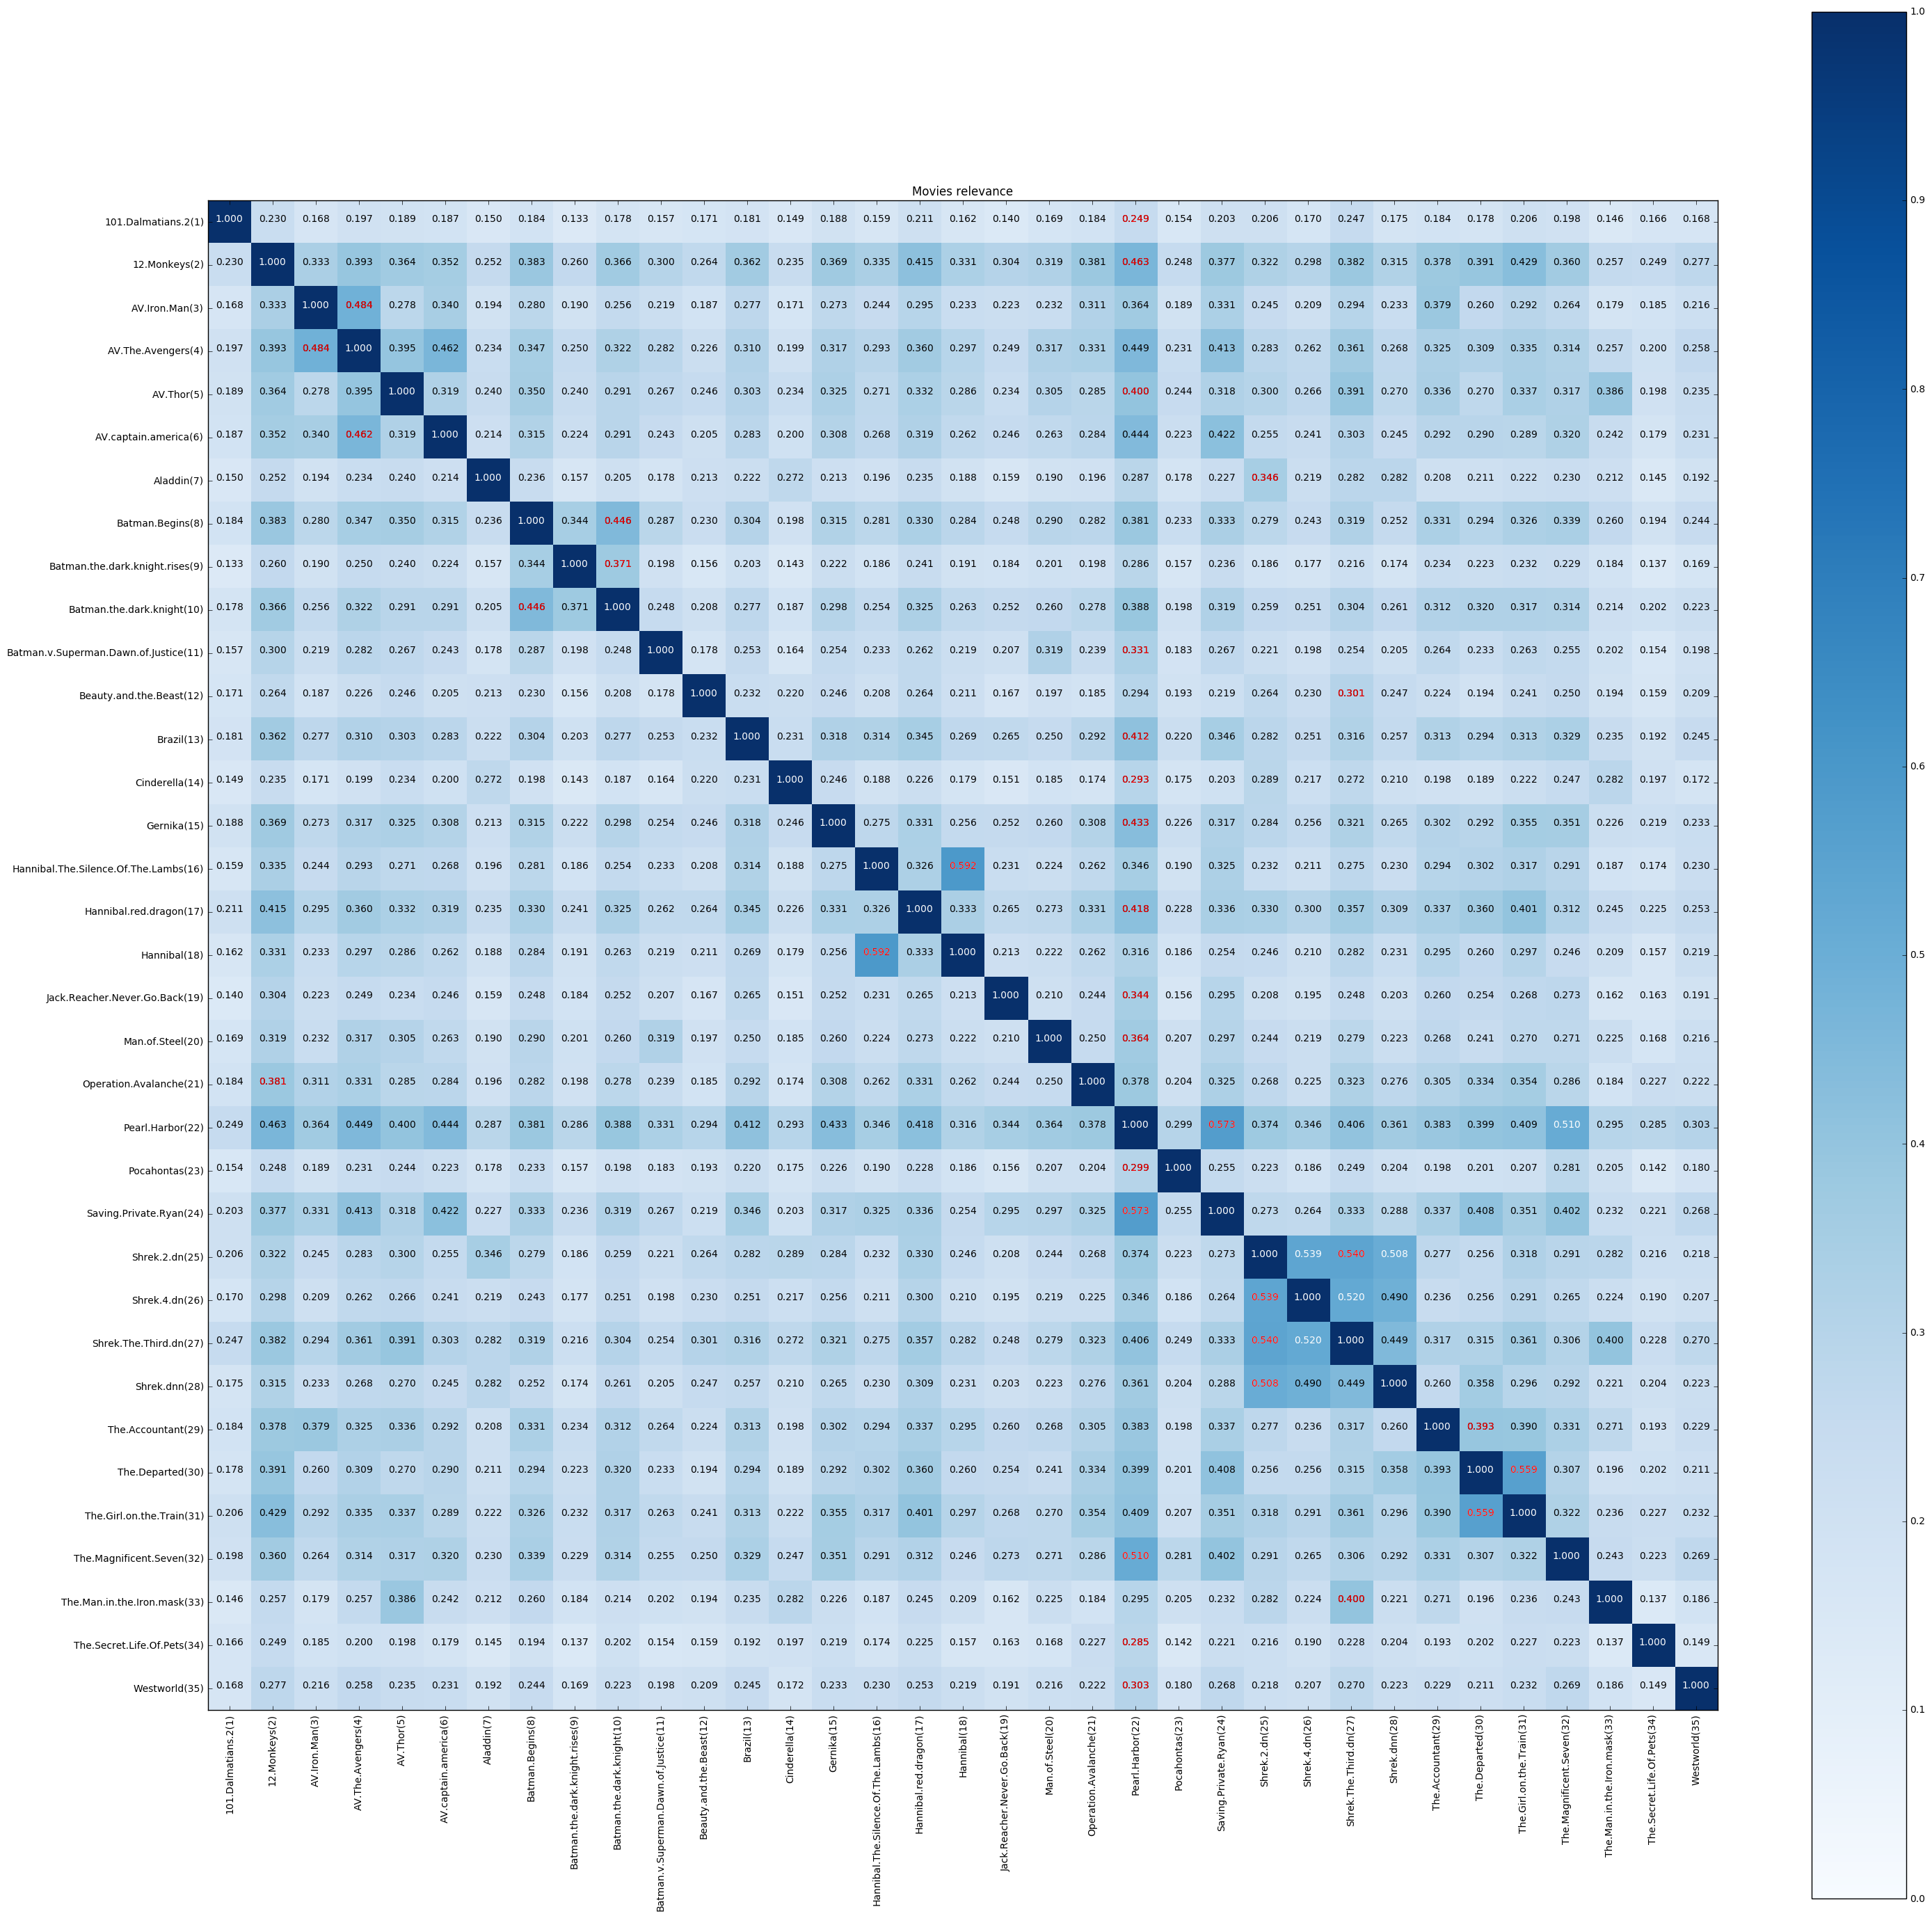

In [122]:
name_data = obtain_subtitle_data(os.listdir(os.getcwd()), dictionary_check=True)
movies_names, subtitles_data = zip(*name_data)
plot_confusion_matrix(texts_relevance(subtitles_data), movies_names,title='Movies relevance')

Words Title
1733 The.Departed(30)


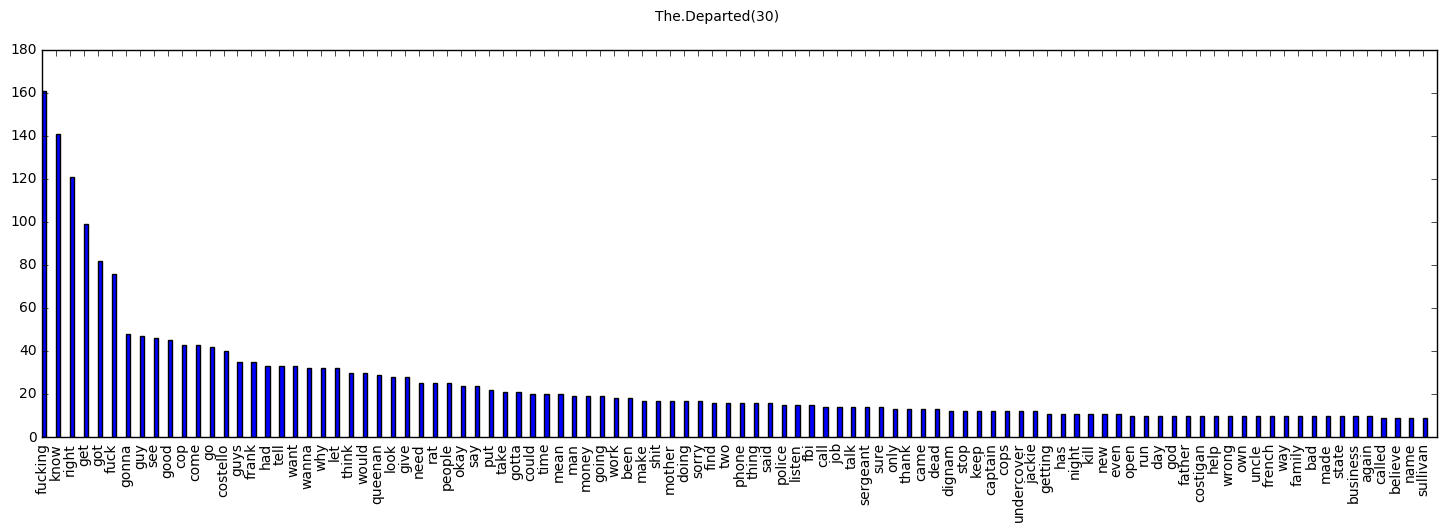

Words Title
898 The.Girl.on.the.Train(31)


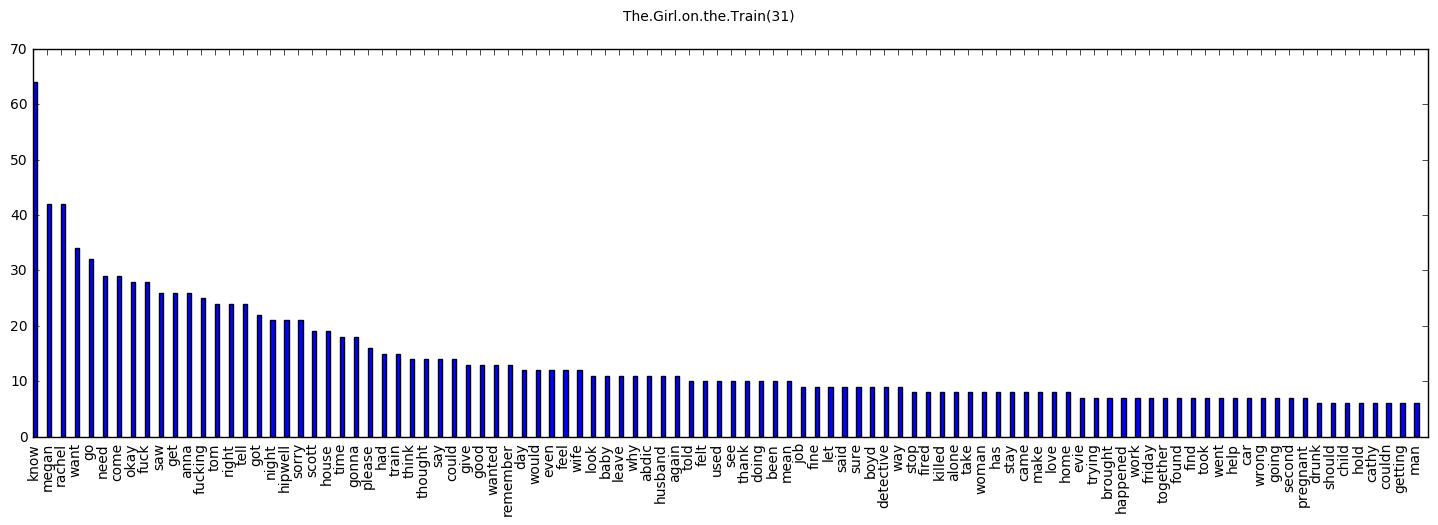

In [117]:
subtitle_histogram(name_data[29][1], title=name_data[29][0], display_word_count=True, number_of_words=100)
subtitle_histogram(name_data[30][1], title=name_data[30][0], display_word_count=True, number_of_words=100)